# Section 3.2 — Confidence intervals

This notebook contains the code examples from [Section 3.2 Confidence intervals]() of the **No Bullshit Guide to Statistics**.


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import plot_pdf
from plot_helpers import savefigure

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
# RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/confidence_intervals"

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

In [5]:
#######################################################

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

$$
\newcommand{\CI}[1]{\textbf{CI}_{#1}}
\newcommand{\CIL}[1]{\textbf{L}_{#1}}
\newcommand{\CIU}[1]{\textbf{U}_{#1}}
\newcommand{\ci}[1]{\textbf{ci}_{#1}}
\newcommand{\cil}[1]{\textbf{l}_{#1}}
\newcommand{\ciu}[1]{\textbf{u}_{#1}}
$$


(this cell contains the macro definitions like $\stderr{\overline{\mathbf{x}}}$, $\stderrhat{}$, $\Mean$, ...)

## Definitions



### Review of estimators

Recall all the estimators (functions that take samples as inputs) we defined in the previous section.

In [6]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)

def dmeans(xsample, ysample):
    dhat = mean(xsample) - mean(ysample)
    return dhat

Saved figure to figures/stats/confidence_intervals/confidence_intervals_mean_rvX_n20.pdf
Saved figure to figures/stats/confidence_intervals/confidence_intervals_mean_rvX_n20.png


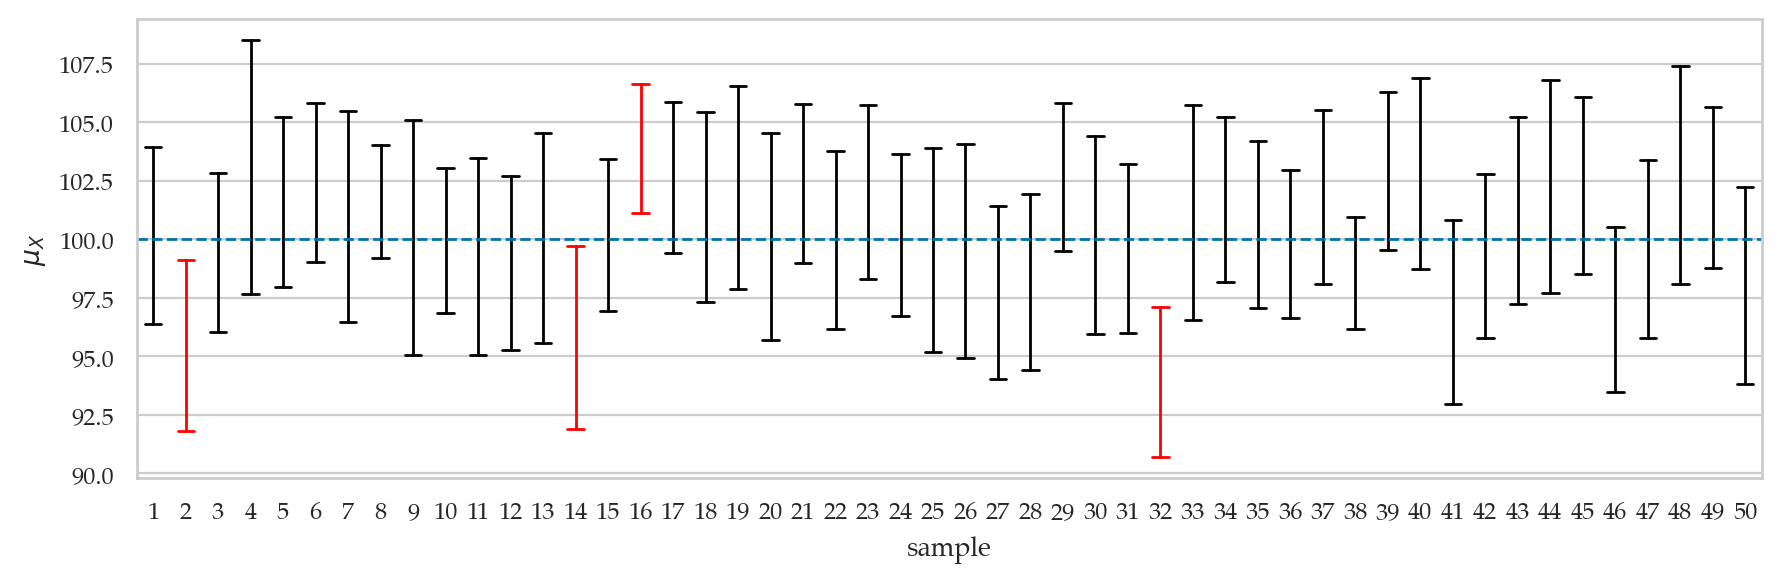

In [7]:
filename = os.path.join(DESTDIR, "confidence_intervals_mean_rvX_n20.pdf")

from scipy.stats import norm
from plot_helpers import gen_samples
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
palette = sns.color_palette(palette=["#ff0000", "#000000"])

N = 50
n = 20

rvX = norm(100,10)

# Generate N=50 samples of size n=20 from a normal dist
np.random.seed(47)
samples_df = gen_samples(rvX, n=n, N=N)
samples_df.columns = range(1,N+1)
df2 = samples_df.melt(var_name="sample", value_name="n")

def confint(data):
    """
    Compute 90% confidence interval.
    Note:  1.729 = tdist(19).ppf(0.95)
    """
    n = len(data)
    mean = data.mean()
    std = data.std(ddof=1)
    se = std / np.sqrt(n)
    return [mean - 1.729*se, mean + 1.729*se]

# Add new column to indicate if CI contains mean or not
for sidx in range(1,N+1):
    sample = df2[df2["sample"]==sidx]["n"].values
    C_L, C_U = confint(sample)
    if C_L <= rvX.mean() and rvX.mean() <= C_U:
        outcome = 1  # includes population mean
    else:
        outcome = 0  # doesn't include population mean
    df2.loc[df2["sample"]==sidx,"success"] = outcome


with warnings.catch_warnings(), plt.rc_context({"figure.figsize":(9,3)}):
    warnings.filterwarnings('ignore', category=UserWarning)    
    ax = sns.pointplot(x="sample", y="n", hue="success", data=df2,
                       errorbar=confint, palette=palette,
                       join=False, capsize=0.5, markers=" ", errwidth=1)
    ax.set_ylabel("$\mu_X$") # "$\overline{\mathbf{x}}$"
    ax.axhline(y=rvX.mean(), color='b', label='Mean', linestyle='--', linewidth=1)
    ax.legend([],[], frameon=False)
    savefigure(ax, filename)

## Confidence interval constructions

$$
 \CI{1-\alpha} = \left[
         F^{-1}\big(\tfrac{\alpha}{2}\big),
         F^{-1}\big(1-\tfrac{\alpha}{2}\big)
      \right]
$$

### Bootstrap confidence intervals

In [29]:
xsample = [1,2,3,4,5,6,7]

from stats_helpers import gen_boot_dist
xbars_boot = gen_boot_dist(xsample, estfunc=mean)

[np.percentile(xbars_boot,5),
 np.percentile(xbars_boot,95)]

[2.7142857142857144, 5.285714285714286]

In [26]:
[np.quantile(xbars_boot,0.05),
 np.quantile(xbars_boot,0.95)]

[2.7142857142857144, 5.142857142857143]

### Analytical approximations

$$
 \CI{\mu_X,1-\alpha} = \left[
         F_{T_{\overline{\mathbf{X}}}}^{-1}\big(\tfrac{\alpha}{2}\big),
         F_{T_{\overline{\mathbf{X}}}}^{-1}\big(1-\tfrac{\alpha}{2}\big)
      \right]
$$

$$
 \CI{\mu_X} = \left[
         F_{T}^{-1}\big(\tfrac{\alpha}{2}\big),
         F_{T}^{-1}\big(1-\tfrac{\alpha}{2}\big)
      \right]
$$

In [27]:
xsample = [1,2,3,4,5,6,7]
n = len(xsample)
xbar = mean(xsample) 
sehat = std(xsample) / np.sqrt(n)

In [28]:
from scipy.stats import t as tdist
rvTXbar = tdist(df=n-1, loc=xbar, scale=sehat)
[rvTXbar.ppf(0.05), rvTXbar.ppf(0.95)]

[2.4133999449331136, 5.586600055066886]

## Confidence interval for the population mean

### Example 1: confidence interval for the mean apple weight

In [12]:
apples = pd.read_csv("../datasets/apples.csv")
asample = apples["weight"]
asample.values

array([205., 182., 192., 189., 217., 192., 210., 240., 225., 191., 193.,
       209., 167., 183., 210., 198., 239., 188., 179., 182., 200., 197.,
       245., 192., 201., 218., 198., 211., 208., 217.])

In [43]:
n = asample.count()
abar = mean(asample)
asehat = std(asample) / np.sqrt(n)
n,   abar,  asehat

(30, 202.6, 3.3959407817427336)

In [31]:
from scipy.stats import t as tdist
rvT = tdist(n-1)
t_05 = rvT.ppf(0.05)
t_95 = rvT.ppf(0.95)
[abar + t_05*asehat, abar + t_95*asehat]

[196.82986523723363, 208.37013476276636]

In [32]:
# ALT. use the statsmodels function
import statsmodels.stats.api as sms
sms.DescrStatsW(asample).tconfint_mean(alpha=0.1)

(196.82986523723363, 208.37013476276636)

#### Bootstrap confidence interval for the mean

In [36]:
np.random.seed(50)
abars_boot = gen_boot_dist(asample, estfunc=mean)
[np.percentile(abars_boot,5),
 np.percentile(abars_boot,95)]

[197.23333333333332, 208.26666666666668]

In [39]:
# ALT. use the `bootstrap` function from `scipy.stats`
from scipy.stats import bootstrap

np.random.seed(50)
res = bootstrap((asample,), statistic=mean,
                confidence_level=0.9, n_resamples=10000,
                vectorized=False, method='percentile')
[res.confidence_interval.low,
 res.confidence_interval.high]

[197.23333333333332, 208.23333333333332]

## Confidence interval for the population variance

### Example 2: confidence interval for the variance of apple weights

In [44]:
apples = pd.read_csv("../datasets/apples.csv")
asample = apples["weight"]
n = asample.count()
s2 = var(asample)

In [45]:
from scipy.stats import chi2
rvX2 = chi2(n-1)
x2_05 = rvX2.ppf(0.05)
x2_95 = rvX2.ppf(0.95)
[(n-1)*s2/x2_95, (n-1)*s2/x2_05]

[235.7592779198888, 566.5796548600426]

#### Bootstrap confidence interval for the variance

In [60]:
np.random.seed(53)
avars_boot = gen_boot_dist(asample, estfunc=var)
[np.percentile(avars_boot,5),
 np.percentile(avars_boot,95)]

[196.387816091954, 480.82183908046]

In [61]:
# ALT. use the `bootstrap` function from `scipy.stats`
from scipy.stats import bootstrap

np.random.seed(53)
res = bootstrap((asample,), statistic=var,
                confidence_level=0.9, n_resamples=10000,
                vectorized=False, method='percentile')
[res.confidence_interval.low,
 res.confidence_interval.high]

[196.7790229885057, 484.6086781609193]

## Confidence interval for the difference between means

### Example 3: confidence interval for difference in electricity prices

In [20]:
eprices = pd.read_csv("../datasets/eprices.csv")
pricesW = eprices[eprices["end"]=="West"]["price"]
pricesE = eprices[eprices["end"]=="East"]["price"]

# sample size and std in West and East
stdW, nW = pricesW.std(), pricesW.count()
stdE, nE = pricesE.std(), pricesE.count()

# center of the CI
dhat = dmeans(pricesW, pricesE)

# standard error
seD = np.sqrt(stdW**2/nW + stdE**2/nE)

In [ ]:
# degrees of freedom
from stats_helpers import calcdf
df = calcdf(stdW, nW, stdE, nE)

In [21]:
from scipy.stats import t as tdist
rvT = tdist(df)
t_05 = rvT.ppf(0.05)
t_95 = rvT.ppf(0.95)

[dhat + t_05*seD, dhat + t_95*seD]

[1.9396575883681457, 4.060342411631854]

In [22]:
# ALT. using statsmodels
import statsmodels.stats.api as sms
statsW = sms.DescrStatsW(pricesW)
statsE = sms.DescrStatsW(pricesE)
cm = sms.CompareMeans(statsW, statsE)
cm.tconfint_diff(alpha=0.1, usevar='unequal')

(1.9396575883681464, 4.060342411631853)

In [65]:
# ALT2. using pingouin
import pingouin as pg
res = pg.ttest(pricesW, pricesE, confidence=0.9, correction=True)
res["CI90%"].values[0]

array([1.93965759, 4.06034241])

#### Bootstrap confidence interval

In [24]:
# compute bootstrap estimates for mean in each group
np.random.seed(42)
meanW_boot = gen_boot_dist(pricesW, estfunc=mean)
meanE_boot = gen_boot_dist(pricesE, estfunc=mean)

# compute the difference between means of bootstrap samples
dmeans_boot = np.subtract(meanW_boot, meanE_boot)

[np.percentile(dmeans_boot,5),
 np.percentile(dmeans_boot,95)]

[2.0666666666666664, 3.933888888888892]

## Explanations

### Frequentist interpretation

Guarantees for confidence intervals given in terms of $\mathbb{E}_\mathbf{X}$, the expectation over a random sample \mathbf{X}. These guarantees can be interpreted as long-term average error rates if the statistical procedure were performed many times (frequentist paradigm).
Note in the frequentist paradigm gives no guarantee about any specific confidence interval—only gives guarantee about the performance of the procedure we used for computing the CIs.

### Assumptions

condensed mention of:    (full discussion of assumptions in Sec 3.4)
Parametric model assumption (conceptual)  cf. nonparametric methods

- (NORM): the population is normally distributed (normality test)
- (LARGEn): the sample size is “large enough” for approximate normality
- (EQVAR): the variance in two groups is the same


## Discussion

### Comparing analytical formulas and bootstrap estimates


### Alternative bootstrap confidence intervals

Mention more advanced bootstrap methods like BCa exist (--> see problem PZZ)

### Factors that influence confidence intervals

- n
- model
- estimator
